## Features:
 - outs, on_1b, on_2b, on_3b, launch_speed, launch_angle, spray_angle, batter_speed, fielder_positioning, OAA_for_batter_handedness (for current game yr, standardized)

In [143]:
import pandas as pd
import numpy as np
import xgboost as xgb
from src.data.data_utils import query_mlb_db
from src.features import build_features as f
from importlib import reload
reload(f)

X_train, y_train, X_test, y_test, encoders = f.get_hit_classification_dataset(split=True)

In [145]:
X_train.head()

,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name,speed
0,25,2017,0,0,0,0,1,1,96.1,18,20.0,5,26.030000
1,25,2017,1,1,0,0,0,1,98.8,16,30.0,5,25.150000
2,25,2017,1,1,1,0,2,1,75.7,1,-14.0,5,27.301339
3,4,2017,0,0,0,0,2,1,84.9,23,51.0,5,27.301339
4,4,2017,1,0,0,0,2,1,102.2,17,47.0,5,27.301339


In [ ]:
def fit_and_test_xgboost(target_col):
    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.1],
        'max_depth': [2, 3],
        'n_estimators': [200, 300],
        'lambda': [0.1, 0.5, 1.0],          # L2 regularization term
        'alpha': [0, 0.1, 0.5],             # L1 regularization term
        #'min_child_weight': [1, 5, 10]      # Minimum sum of instance weight (hessian)
    }

    clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='neg_log_loss', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    best_clf = grid_search.best_estimator_
    best_clf.fit(X_train, y_train)
    clf = best_clf
    
    xgb_loglik = compute_xgboost_loglik(clf.predict_proba(X_test), y_test, target_col)
    cat_loglik = compute_cat_loglik(X_train, y_train, y_test, target_col)
    print(f'XGB: {xgb_loglik:.2f}, CAT: {cat_loglik:.2f}')
    print(f"Train Accuracy: {accuracy_score(y_train, clf.predict(X_train)):.3f}")
    print(f"Train Accuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}")

for batter in [vladdy, soto, schneider, biggio]:
    fit_and_test_xgboost(batter, 'pitch_outcome')

In [146]:
clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [150]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 0.7832301852925229
Accuracy: 0.7761190441848166


In [165]:
y_test_lab = encoders['simplified_outcome'].inverse_transform(y_train['simplified_outcome'])
y_pred_lab = encoders['simplified_outcome'].inverse_transform(clf.predict(X_train))

In [166]:
unique_labels = np.unique(np.concatenate((y_test_lab, y_pred_lab)))
unique_labels

array(['double', 'double_play', 'field_out', 'fielders_choice',
       'fielding_error', 'fly_out', 'ground_out', 'home_run', 'single',
       'triple', 'triple_play'], dtype=object)

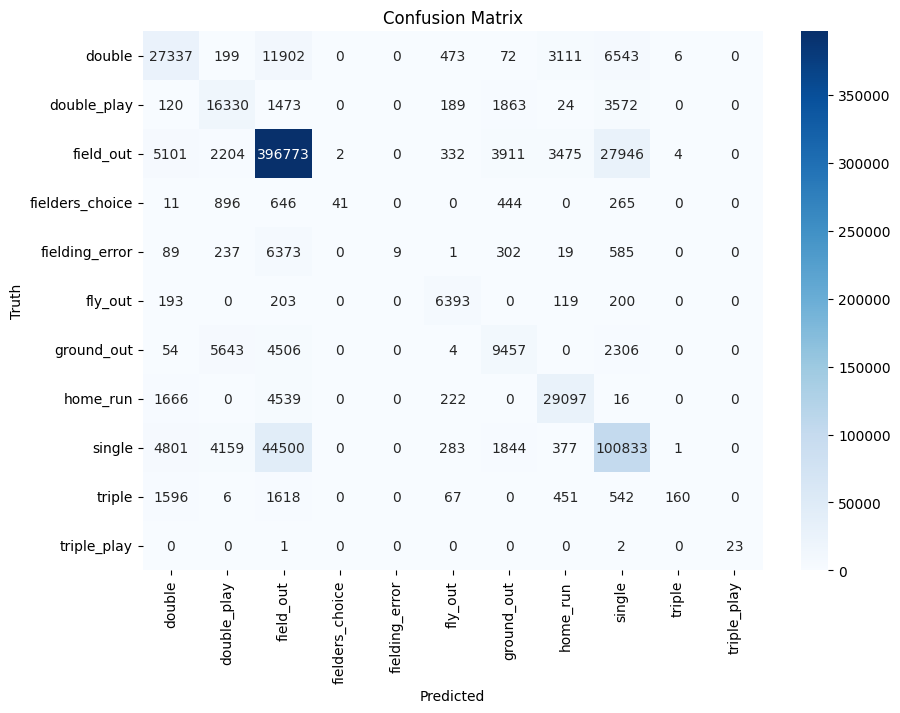

In [167]:
cm = confusion_matrix(y_test_lab, y_pred_lab)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
plt.show()

In [220]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [230]:
t = pd.DataFrame(X_train.iloc[[14]])

t['venue_name'] = [7]
t['launch_angle'] = [30]
t['spray_angle'] = 0
t['launch_speed'] = [95]

np.set_printoptions(suppress=True)
pd.DataFrame(clf.predict_proba(t))

,0,1,2,3,4,5,6,7,8,9,10
0,0.01819,0.000153,0.597704,0.000003,0.005889,0.000026,0.000002,0.354368,0.007197,0.016468,3.170622e-07


In [209]:
np.set_printoptions(suppress=True)
pd.DataFrame(clf.predict_proba(t))

,0,1,2,3,4,5,6,7,8,9,10
0,0.006979,0.492116,0.068346,0.032265,0.004281,0.000001,0.173056,0.000011,0.222711,0.00023,0.000004


In [206]:
pd.DataFrame(encoders['simplified_outcome'].inverse_transform(list(range(11)))).T


,0,1,2,3,4,5,6,7,8,9,10
0,double,double_play,field_out,fielders_choice,fielding_error,fly_out,ground_out,home_run,single,triple,triple_play


In [201]:
pd.DataFrame(encoders['venue_name'].inverse_transform(list(range(39))))

,0
0,AT&T Park
1,American Family Field
2,Angel Stadium
3,Angel Stadium of Anaheim
4,BayCare Ballpark
5,Busch Stadium
6,Chase Field
7,Citi Field
8,Citizens Bank Park
9,Clover Park


In [ ]:
0
0	AT&T Park
1	American Family Field
2	Angel Stadium
3	Angel Stadium of Anaheim
4	BayCare Ballpark
5	Busch Stadium
6	Chase Field
7	Citi Field
8	Citizens Bank Park
9	Clover Park
10	Comerica Park
11	Coors Field
12	Dodger Stadium
13	Fenway Park
14	George M. Steinbrenner Field
15	Globe Life Field
16	Globe Life Park in Arlington
17	Great American Ball Park
18	Guaranteed Rate Field
19	Hammond Stadium
20	Kauffman Stadium
21	LECOM Park
22	Las Vegas Ballpark
23	Lee Health Sports Complex
24	Marlins Park
25	Miller Park
26	Minute Maid Park
27	Nationals Park
28	Oakland Coliseum
29	Oracle Park
30	Oriole Park at Camden Yards
31	PNC Park
32	Petco Park
33	Progressive Field
34	Publix Field at Joker Marchant Stadium
35	Roger Dean Chevrolet Stadium
36	Rogers Centre
37	Safeco Field
38	Sahlen Field

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

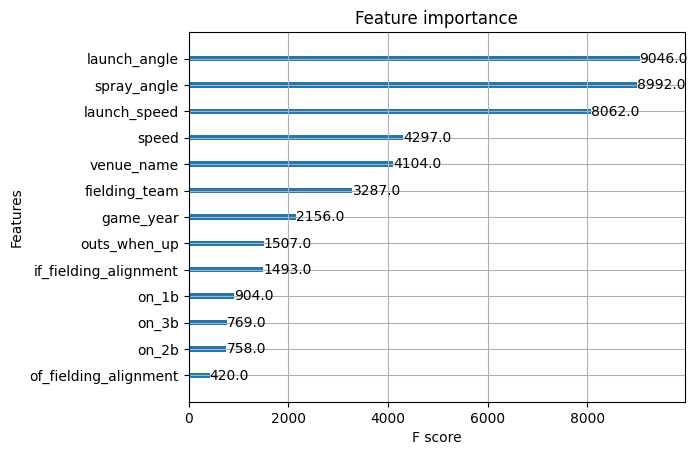

In [149]:
xgb.plot_importance(clf)

In [147]:
def compute_xgboost_loglik(y_pred_proba, y_test, target_col):
    loglik = 0
    for idx, target in enumerate(y_test[target_col]):
        loglik += np.log(y_pred_proba[idx, target])
    return loglik

def compute_cat_loglik(X_train, y_train, y_test, target_col):

    df = pd.concat([X_train, y_train], axis=1)
    
    pitch_cat_prob = (df[target_col].value_counts() / len(df)) #.reset_index()
    #pitch_cat_prob[f'{target_col}_encoded'] = encoders[target_col].transform(pitch_cat_prob[target_col])
    #pitch_cat_prob.set_index(f'{target_col}_encoded')
    
    loglik = 0
    for target in y_test[target_col]:
        loglik += np.log(pitch_cat_prob.loc[target])
    return loglik

target_col = 'simplified_outcome'
xgb_loglik = compute_xgboost_loglik(clf.predict_proba(X_test), y_test, target_col)
cat_loglik = compute_cat_loglik(X_train, y_train, y_test, target_col)
print(f'XGB: {xgb_loglik:.2f}, CAT: {cat_loglik:.2f}')

XGB: -48975.96, CAT: -108199.58


In [123]:
df = query_mlb_db("""
    SELECT
    CASE
        WHEN events IN ('single') THEN 'single'
        WHEN events IN ('double') THEN 'double'
        WHEN events IN ('triple') THEN 'triple'
        WHEN events IN ('home_run') THEN 'home_run'
		WHEN events IN ('field_out') THEN 'field_out'
        WHEN events IN ('ground_out', 'force_out') THEN 'ground_out'
        WHEN events IN ('fly_out', 'sac_fly') THEN 'fly_out'
        WHEN events IN ('double_play', 'grounded_into_double_play', 'sac_fly_double_play') THEN 'double_play'
        WHEN events IN ('triple_play') THEN 'triple_play'
        WHEN events IN ('field_error') THEN 'fielding_error'
        WHEN events IN ('fielders_choice') THEN 'fielders_choice'
        ELSE NULL
    END AS simplified_outcome,
	game_pk, batter,
    case when inning_topbot='Top' then home_team else away_team end as 'fielding_team',
    game_year, outs_when_up, 
	case when on_1b is not null then 1 else 0 end as on_1b,
	case when on_2b is not null then 1 else 0 end as on_2b,
	case when on_3b is not null then 1 else 0 end as on_3b,
	
	if_fielding_alignment, of_fielding_alignment,
	launch_speed, launch_angle, ROUND((-(180 / PI()) * atan2(hc_x - 130, 213 - hc_y) + 90)) as spray_angle
FROM
    Statcast
WHERE type='X'
and 
simplified_outcome &
game_year & outs_when_up & of_fielding_alignment &
launch_speed & launch_angle & spray_angle is not null
ORDER BY GAME_DATE ASC;
""")
df.head()

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0


In [126]:
speed_df = query_mlb_db('select mlb_id as batter, speed from PlayerSpeed;')
speed_df.head()

,batter,speed
0,677951,30.41
1,687363,30.37
2,607208,30.37
3,682829,30.34
4,669352,30.30


In [127]:
oaa_df = query_mlb_db('select * from TeamOAA;')
oaa_df.head()

,year,entity_id,entity_name,oaa_rhh,oaa_lhh,oaa_rhh_standardized,oaa_lhh_standardized
0,2021,108,Angels,-8,-6,-0.986031,-1.104716
1,2022,108,Angels,2,6,0.088866,0.995313
2,2023,108,Angels,0,4,-0.191144,0.873324
3,2024,108,Angels,0,3,-0.052330,0.907826
4,2021,109,D-backs,3,-4,0.300096,-0.710175


In [128]:
venue_df = query_mlb_db('select game_pk, venue_name from VenueGamePkMapping;')
venue_df.head()

,game_pk,venue_name
0,490099,Busch Stadium
1,490106,Tropicana Field
2,490110,Chase Field
3,490098,Citi Field
4,490100,Globe Life Park in Arlington


In [129]:
df = df.merge(venue_df, how='left', on='game_pk')
df

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,747121,518595,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park
831954,ground_out,747121,594807,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park
831955,field_out,747121,671739,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park
831956,field_out,747121,592518,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park


In [130]:
df = df.merge(speed_df, how='left', on='batter')
df['speed'] = df['speed'].astype(float)
df['speed'] = df['speed'].fillna(t['speed'].mean())
df

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name,speed
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium,26.030000
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium,25.150000
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium,27.301339
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium,27.301339
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium,27.301339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,747121,518595,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park,26.200000
831954,ground_out,747121,594807,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park,28.160000
831955,field_out,747121,671739,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park,28.990000
831956,field_out,747121,592518,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park,26.350000


In [136]:
df.drop(['batter', 'game_pk'], axis=1)

,simplified_outcome,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name,speed
0,single,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium,26.030000
1,single,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium,25.150000
2,double_play,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium,27.301339
3,field_out,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium,27.301339
4,double,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium,27.301339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park,26.200000
831954,ground_out,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park,28.160000
831955,field_out,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park,28.990000
831956,field_out,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park,26.350000
